In [20]:
import torch
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, MarianMTModel, MarianTokenizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
import langid

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
merged = pd.read_csv('../data/merged.csv')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=210)
model.load_state_dict(torch.load('../models/massive-us-en.pt', map_location=torch.device('cpu')))
model.eval()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.we

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [21]:
def classify_intent(user_input_text, tokenizer, model):
    user_input = tokenizer(user_input_text, truncation=True, padding=True)
    input_ids = torch.tensor(user_input['input_ids']).unsqueeze(0)
    attention_mask = torch.tensor(user_input['attention_mask']).unsqueeze(0)
    outputs = model(input_ids, attention_mask=attention_mask)
    scores = outputs[0].detach().numpy().flatten()
    probs = np.exp(scores) / np.sum(np.exp(scores))
    _labels = merged['intent'].unique().tolist()

    label_probs = {}
    for i in range(len(probs)):
        label_probs[_labels[i]] = float(probs[i])

    sorted_labels = sorted(label_probs.items(), key=lambda x: x[1], reverse=True)

    result = {
        'input': user_input_text,
        'intent_probabilities': sorted_labels
    }

    return result

In [22]:
def evaluate_model(test_data, tokenizer, model):
    y_true = test_data['intent']
    y_pred = []
    for text in test_data['utt']:
        result = classify_intent(text, tokenizer, model)
        y_pred.append(result['intent_probabilities'][0][0])  # Taking the top predicted intent

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    confusion_mat = pd.crosstab(pd.Series(y_true, name='Actual'), pd.Series(y_pred, name='Predicted'))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

{'input': 'switch on lights now', 'intent_probabilities': [('calendar_set', 0.02143539860844612), ('lists_query', 0.02140536904335022), ('takeaway_order', 0.020320797339081764), ('iot_cleaning', 0.020063361153006554), ('iot_coffee', 0.019175972789525986), ('play_radio', 0.018994657322764397), ('email_addcontact', 0.018714170902967453), ('qa_currency', 0.01842714101076126), ('calendar_remove', 0.01840995065867901), ('audio_volume_mute', 0.018348272889852524), ('recommendation_events', 0.01833002269268036), ('alarm_set', 0.018256522715091705), ('transport_taxi', 0.01824432797729969), ('datetime_convert', 0.018123889341950417), ('iot_hue_lightoff', 0.018039625138044357), ('recommendation_movies', 0.01790924370288849), ('music_query', 0.01786421425640583), ('audio_volume_other', 0.017859745770692825), ('lists_remove', 0.017781779170036316), ('calendar_query', 0.01770181581377983), ('transport_traffic', 0.01763327419757843), ('play_podcasts', 0.017516369000077248), ('weather_query', 0.01734

/Users/Aryan_Goel/intent-classification-model-service/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Aryan_Goel/intent-classification-model-service/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.008027829810008028
Precision: 0.0006792248200562391
Recall: 0.008027829810008028
F1 Score: 0.001043820350270691
Classification Report:
                            precision    recall  f1-score   support

      accept_reservations       0.00      0.00      0.00        30
          account_blocked       0.00      0.00      0.00        30
                    alarm       0.00      0.00      0.00        30
              alarm_query       0.00      0.00      0.00        34
             alarm_remove       0.00      0.00      0.00        21
                alarm_set       0.00      0.00      0.00        41
       application_status       0.00      0.00      0.00        30
                      apr       0.00      0.00      0.00        30
            are_you_a_bot       0.00      0.00      0.00        30
        audio_volume_down       0.00      0.00      0.00        11
        audio_volume_mute       0.00      0.00      0.00        32
       audio_volume_other       0.00      0.00 

/Users/Aryan_Goel/intent-classification-model-service/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Aryan_Goel/intent-classification-model-service/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


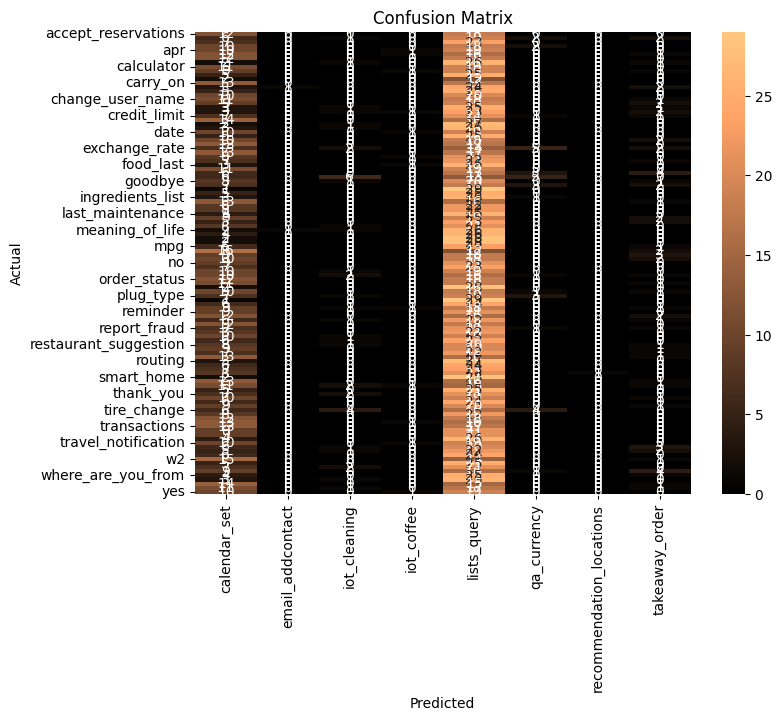

In [27]:
merged_dataset = pd.read_csv('../data/merged.csv')
test_data = merged_dataset[merged_dataset['partition'] == 'test']
user_input_text = "switch on lights now"
result = classify_intent(user_input_text, tokenizer, model)
print(result)

evaluate_model(test_data, tokenizer, model)

In [24]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
merged = pd.read_csv('../data/massive-us-en.csv')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=60)
model.load_state_dict(torch.load('../models/distilbert_bert_ensemble.pt', map_location=torch.device('cpu')))
model.eval()

merged_dataset = pd.read_csv('../data/massive-us-en.csv')
test_data = merged_dataset[merged_dataset['partition'] == 'test']
user_input_text = "Hello how are you today?"
result = classify_intent(user_input_text, tokenizer, model)
print(result)

evaluate_model(test_data, tokenizer, model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.we

RuntimeError: Error(s) in loading state_dict for DistilBertForSequenceClassification:
	Missing key(s) in state_dict: "distilbert.embeddings.word_embeddings.weight", "distilbert.embeddings.position_embeddings.weight", "distilbert.embeddings.LayerNorm.weight", "distilbert.embeddings.LayerNorm.bias", "distilbert.transformer.layer.0.attention.q_lin.weight", "distilbert.transformer.layer.0.attention.q_lin.bias", "distilbert.transformer.layer.0.attention.k_lin.weight", "distilbert.transformer.layer.0.attention.k_lin.bias", "distilbert.transformer.layer.0.attention.v_lin.weight", "distilbert.transformer.layer.0.attention.v_lin.bias", "distilbert.transformer.layer.0.attention.out_lin.weight", "distilbert.transformer.layer.0.attention.out_lin.bias", "distilbert.transformer.layer.0.sa_layer_norm.weight", "distilbert.transformer.layer.0.sa_layer_norm.bias", "distilbert.transformer.layer.0.ffn.lin1.weight", "distilbert.transformer.layer.0.ffn.lin1.bias", "distilbert.transformer.layer.0.ffn.lin2.weight", "distilbert.transformer.layer.0.ffn.lin2.bias", "distilbert.transformer.layer.0.output_layer_norm.weight", "distilbert.transformer.layer.0.output_layer_norm.bias", "distilbert.transformer.layer.1.attention.q_lin.weight", "distilbert.transformer.layer.1.attention.q_lin.bias", "distilbert.transformer.layer.1.attention.k_lin.weight", "distilbert.transformer.layer.1.attention.k_lin.bias", "distilbert.transformer.layer.1.attention.v_lin.weight", "distilbert.transformer.layer.1.attention.v_lin.bias", "distilbert.transformer.layer.1.attention.out_lin.weight", "distilbert.transformer.layer.1.attention.out_lin.bias", "distilbert.transformer.layer.1.sa_layer_norm.weight", "distilbert.transformer.layer.1.sa_layer_norm.bias", "distilbert.transformer.layer.1.ffn.lin1.weight", "distilbert.transformer.layer.1.ffn.lin1.bias", "distilbert.transformer.layer.1.ffn.lin2.weight", "distilbert.transformer.layer.1.ffn.lin2.bias", "distilbert.transformer.layer.1.output_layer_norm.weight", "distilbert.transformer.layer.1.output_layer_norm.bias", "distilbert.transformer.layer.2.attention.q_lin.weight", "distilbert.transformer.layer.2.attention.q_lin.bias", "distilbert.transformer.layer.2.attention.k_lin.weight", "distilbert.transformer.layer.2.attention.k_lin.bias", "distilbert.transformer.layer.2.attention.v_lin.weight", "distilbert.transformer.layer.2.attention.v_lin.bias", "distilbert.transformer.layer.2.attention.out_lin.weight", "distilbert.transformer.layer.2.attention.out_lin.bias", "distilbert.transformer.layer.2.sa_layer_norm.weight", "distilbert.transformer.layer.2.sa_layer_norm.bias", "distilbert.transformer.layer.2.ffn.lin1.weight", "distilbert.transformer.layer.2.ffn.lin1.bias", "distilbert.transformer.layer.2.ffn.lin2.weight", "distilbert.transformer.layer.2.ffn.lin2.bias", "distilbert.transformer.layer.2.output_layer_norm.weight", "distilbert.transformer.layer.2.output_layer_norm.bias", "distilbert.transformer.layer.3.attention.q_lin.weight", "distilbert.transformer.layer.3.attention.q_lin.bias", "distilbert.transformer.layer.3.attention.k_lin.weight", "distilbert.transformer.layer.3.attention.k_lin.bias", "distilbert.transformer.layer.3.attention.v_lin.weight", "distilbert.transformer.layer.3.attention.v_lin.bias", "distilbert.transformer.layer.3.attention.out_lin.weight", "distilbert.transformer.layer.3.attention.out_lin.bias", "distilbert.transformer.layer.3.sa_layer_norm.weight", "distilbert.transformer.layer.3.sa_layer_norm.bias", "distilbert.transformer.layer.3.ffn.lin1.weight", "distilbert.transformer.layer.3.ffn.lin1.bias", "distilbert.transformer.layer.3.ffn.lin2.weight", "distilbert.transformer.layer.3.ffn.lin2.bias", "distilbert.transformer.layer.3.output_layer_norm.weight", "distilbert.transformer.layer.3.output_layer_norm.bias", "distilbert.transformer.layer.4.attention.q_lin.weight", "distilbert.transformer.layer.4.attention.q_lin.bias", "distilbert.transformer.layer.4.attention.k_lin.weight", "distilbert.transformer.layer.4.attention.k_lin.bias", "distilbert.transformer.layer.4.attention.v_lin.weight", "distilbert.transformer.layer.4.attention.v_lin.bias", "distilbert.transformer.layer.4.attention.out_lin.weight", "distilbert.transformer.layer.4.attention.out_lin.bias", "distilbert.transformer.layer.4.sa_layer_norm.weight", "distilbert.transformer.layer.4.sa_layer_norm.bias", "distilbert.transformer.layer.4.ffn.lin1.weight", "distilbert.transformer.layer.4.ffn.lin1.bias", "distilbert.transformer.layer.4.ffn.lin2.weight", "distilbert.transformer.layer.4.ffn.lin2.bias", "distilbert.transformer.layer.4.output_layer_norm.weight", "distilbert.transformer.layer.4.output_layer_norm.bias", "distilbert.transformer.layer.5.attention.q_lin.weight", "distilbert.transformer.layer.5.attention.q_lin.bias", "distilbert.transformer.layer.5.attention.k_lin.weight", "distilbert.transformer.layer.5.attention.k_lin.bias", "distilbert.transformer.layer.5.attention.v_lin.weight", "distilbert.transformer.layer.5.attention.v_lin.bias", "distilbert.transformer.layer.5.attention.out_lin.weight", "distilbert.transformer.layer.5.attention.out_lin.bias", "distilbert.transformer.layer.5.sa_layer_norm.weight", "distilbert.transformer.layer.5.sa_layer_norm.bias", "distilbert.transformer.layer.5.ffn.lin1.weight", "distilbert.transformer.layer.5.ffn.lin1.bias", "distilbert.transformer.layer.5.ffn.lin2.weight", "distilbert.transformer.layer.5.ffn.lin2.bias", "distilbert.transformer.layer.5.output_layer_norm.weight", "distilbert.transformer.layer.5.output_layer_norm.bias", "pre_classifier.weight", "pre_classifier.bias". 
	Unexpected key(s) in state_dict: "bert.embeddings.position_ids", "bert.embeddings.word_embeddings.weight", "bert.embeddings.position_embeddings.weight", "bert.embeddings.token_type_embeddings.weight", "bert.embeddings.LayerNorm.weight", "bert.embeddings.LayerNorm.bias", "bert.encoder.layer.0.attention.self.query.weight", "bert.encoder.layer.0.attention.self.query.bias", "bert.encoder.layer.0.attention.self.key.weight", "bert.encoder.layer.0.attention.self.key.bias", "bert.encoder.layer.0.attention.self.value.weight", "bert.encoder.layer.0.attention.self.value.bias", "bert.encoder.layer.0.attention.output.dense.weight", "bert.encoder.layer.0.attention.output.dense.bias", "bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.encoder.layer.0.intermediate.dense.weight", "bert.encoder.layer.0.intermediate.dense.bias", "bert.encoder.layer.0.output.dense.weight", "bert.encoder.layer.0.output.dense.bias", "bert.encoder.layer.0.output.LayerNorm.weight", "bert.encoder.layer.0.output.LayerNorm.bias", "bert.encoder.layer.1.attention.self.query.weight", "bert.encoder.layer.1.attention.self.query.bias", "bert.encoder.layer.1.attention.self.key.weight", "bert.encoder.layer.1.attention.self.key.bias", "bert.encoder.layer.1.attention.self.value.weight", "bert.encoder.layer.1.attention.self.value.bias", "bert.encoder.layer.1.attention.output.dense.weight", "bert.encoder.layer.1.attention.output.dense.bias", "bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.encoder.layer.1.intermediate.dense.weight", "bert.encoder.layer.1.intermediate.dense.bias", "bert.encoder.layer.1.output.dense.weight", "bert.encoder.layer.1.output.dense.bias", "bert.encoder.layer.1.output.LayerNorm.weight", "bert.encoder.layer.1.output.LayerNorm.bias", "bert.encoder.layer.2.attention.self.query.weight", "bert.encoder.layer.2.attention.self.query.bias", "bert.encoder.layer.2.attention.self.key.weight", "bert.encoder.layer.2.attention.self.key.bias", "bert.encoder.layer.2.attention.self.value.weight", "bert.encoder.layer.2.attention.self.value.bias", "bert.encoder.layer.2.attention.output.dense.weight", "bert.encoder.layer.2.attention.output.dense.bias", "bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.encoder.layer.2.intermediate.dense.weight", "bert.encoder.layer.2.intermediate.dense.bias", "bert.encoder.layer.2.output.dense.weight", "bert.encoder.layer.2.output.dense.bias", "bert.encoder.layer.2.output.LayerNorm.weight", "bert.encoder.layer.2.output.LayerNorm.bias", "bert.encoder.layer.3.attention.self.query.weight", "bert.encoder.layer.3.attention.self.query.bias", "bert.encoder.layer.3.attention.self.key.weight", "bert.encoder.layer.3.attention.self.key.bias", "bert.encoder.layer.3.attention.self.value.weight", "bert.encoder.layer.3.attention.self.value.bias", "bert.encoder.layer.3.attention.output.dense.weight", "bert.encoder.layer.3.attention.output.dense.bias", "bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.encoder.layer.3.intermediate.dense.weight", "bert.encoder.layer.3.intermediate.dense.bias", "bert.encoder.layer.3.output.dense.weight", "bert.encoder.layer.3.output.dense.bias", "bert.encoder.layer.3.output.LayerNorm.weight", "bert.encoder.layer.3.output.LayerNorm.bias", "bert.encoder.layer.4.attention.self.query.weight", "bert.encoder.layer.4.attention.self.query.bias", "bert.encoder.layer.4.attention.self.key.weight", "bert.encoder.layer.4.attention.self.key.bias", "bert.encoder.layer.4.attention.self.value.weight", "bert.encoder.layer.4.attention.self.value.bias", "bert.encoder.layer.4.attention.output.dense.weight", "bert.encoder.layer.4.attention.output.dense.bias", "bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.encoder.layer.4.intermediate.dense.weight", "bert.encoder.layer.4.intermediate.dense.bias", "bert.encoder.layer.4.output.dense.weight", "bert.encoder.layer.4.output.dense.bias", "bert.encoder.layer.4.output.LayerNorm.weight", "bert.encoder.layer.4.output.LayerNorm.bias", "bert.encoder.layer.5.attention.self.query.weight", "bert.encoder.layer.5.attention.self.query.bias", "bert.encoder.layer.5.attention.self.key.weight", "bert.encoder.layer.5.attention.self.key.bias", "bert.encoder.layer.5.attention.self.value.weight", "bert.encoder.layer.5.attention.self.value.bias", "bert.encoder.layer.5.attention.output.dense.weight", "bert.encoder.layer.5.attention.output.dense.bias", "bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.encoder.layer.5.intermediate.dense.weight", "bert.encoder.layer.5.intermediate.dense.bias", "bert.encoder.layer.5.output.dense.weight", "bert.encoder.layer.5.output.dense.bias", "bert.encoder.layer.5.output.LayerNorm.weight", "bert.encoder.layer.5.output.LayerNorm.bias", "bert.encoder.layer.6.attention.self.query.weight", "bert.encoder.layer.6.attention.self.query.bias", "bert.encoder.layer.6.attention.self.key.weight", "bert.encoder.layer.6.attention.self.key.bias", "bert.encoder.layer.6.attention.self.value.weight", "bert.encoder.layer.6.attention.self.value.bias", "bert.encoder.layer.6.attention.output.dense.weight", "bert.encoder.layer.6.attention.output.dense.bias", "bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.encoder.layer.6.intermediate.dense.weight", "bert.encoder.layer.6.intermediate.dense.bias", "bert.encoder.layer.6.output.dense.weight", "bert.encoder.layer.6.output.dense.bias", "bert.encoder.layer.6.output.LayerNorm.weight", "bert.encoder.layer.6.output.LayerNorm.bias", "bert.encoder.layer.7.attention.self.query.weight", "bert.encoder.layer.7.attention.self.query.bias", "bert.encoder.layer.7.attention.self.key.weight", "bert.encoder.layer.7.attention.self.key.bias", "bert.encoder.layer.7.attention.self.value.weight", "bert.encoder.layer.7.attention.self.value.bias", "bert.encoder.layer.7.attention.output.dense.weight", "bert.encoder.layer.7.attention.output.dense.bias", "bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.encoder.layer.7.intermediate.dense.weight", "bert.encoder.layer.7.intermediate.dense.bias", "bert.encoder.layer.7.output.dense.weight", "bert.encoder.layer.7.output.dense.bias", "bert.encoder.layer.7.output.LayerNorm.weight", "bert.encoder.layer.7.output.LayerNorm.bias", "bert.encoder.layer.8.attention.self.query.weight", "bert.encoder.layer.8.attention.self.query.bias", "bert.encoder.layer.8.attention.self.key.weight", "bert.encoder.layer.8.attention.self.key.bias", "bert.encoder.layer.8.attention.self.value.weight", "bert.encoder.layer.8.attention.self.value.bias", "bert.encoder.layer.8.attention.output.dense.weight", "bert.encoder.layer.8.attention.output.dense.bias", "bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.encoder.layer.8.intermediate.dense.weight", "bert.encoder.layer.8.intermediate.dense.bias", "bert.encoder.layer.8.output.dense.weight", "bert.encoder.layer.8.output.dense.bias", "bert.encoder.layer.8.output.LayerNorm.weight", "bert.encoder.layer.8.output.LayerNorm.bias", "bert.encoder.layer.9.attention.self.query.weight", "bert.encoder.layer.9.attention.self.query.bias", "bert.encoder.layer.9.attention.self.key.weight", "bert.encoder.layer.9.attention.self.key.bias", "bert.encoder.layer.9.attention.self.value.weight", "bert.encoder.layer.9.attention.self.value.bias", "bert.encoder.layer.9.attention.output.dense.weight", "bert.encoder.layer.9.attention.output.dense.bias", "bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.encoder.layer.9.intermediate.dense.weight", "bert.encoder.layer.9.intermediate.dense.bias", "bert.encoder.layer.9.output.dense.weight", "bert.encoder.layer.9.output.dense.bias", "bert.encoder.layer.9.output.LayerNorm.weight", "bert.encoder.layer.9.output.LayerNorm.bias", "bert.encoder.layer.10.attention.self.query.weight", "bert.encoder.layer.10.attention.self.query.bias", "bert.encoder.layer.10.attention.self.key.weight", "bert.encoder.layer.10.attention.self.key.bias", "bert.encoder.layer.10.attention.self.value.weight", "bert.encoder.layer.10.attention.self.value.bias", "bert.encoder.layer.10.attention.output.dense.weight", "bert.encoder.layer.10.attention.output.dense.bias", "bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.encoder.layer.10.intermediate.dense.weight", "bert.encoder.layer.10.intermediate.dense.bias", "bert.encoder.layer.10.output.dense.weight", "bert.encoder.layer.10.output.dense.bias", "bert.encoder.layer.10.output.LayerNorm.weight", "bert.encoder.layer.10.output.LayerNorm.bias", "bert.encoder.layer.11.attention.self.query.weight", "bert.encoder.layer.11.attention.self.query.bias", "bert.encoder.layer.11.attention.self.key.weight", "bert.encoder.layer.11.attention.self.key.bias", "bert.encoder.layer.11.attention.self.value.weight", "bert.encoder.layer.11.attention.self.value.bias", "bert.encoder.layer.11.attention.output.dense.weight", "bert.encoder.layer.11.attention.output.dense.bias", "bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.encoder.layer.11.intermediate.dense.weight", "bert.encoder.layer.11.intermediate.dense.bias", "bert.encoder.layer.11.output.dense.weight", "bert.encoder.layer.11.output.dense.bias", "bert.encoder.layer.11.output.LayerNorm.weight", "bert.encoder.layer.11.output.LayerNorm.bias", "bert.pooler.dense.weight", "bert.pooler.dense.bias". 